# Exercise Project

(TKO_2027-3001)

</br>

**Oona Leppänen**
</br>
1800509
</br>
oklepp@utu.fi

</br>

The idea of the project is to train a CNN model to classify (differentiate) covid-19, pneumonia and healthy patients from each other based on X-ray images of human patients' chests. First the CNN model is trained with Pneumonia dataset having only pneumonia and healthy patients. Then the created base model is fine-tuned with Covid-19 dataset having covid-19, pneumonia and healthy patients.

## Importing packages

In [1]:
import numpy as np
import glob
import matplotlib.pyplot as plt

import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, Rescaling, Conv2D, MaxPooling2D, Flatten, Dense

import albumentations as A
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import PIL

## Loading the data

Run the below code block when loading data from Google Drive.

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Pneumonia dataset

Pneumonia dataset consists of X-ray images of human chests. The chests are either healthy (also word 'normal' is used here) or they have pneumonia.

The dataset has 5856 images divided into training, validation and test sets with 4192, 1040 and 624 images, respectively. The training set consists of 1082 healthy cases and 3110 pneumonia cases, the validation set consists of 267 healthy and 773 pneumonia cases and the test set consists of 234 healthy and 390 pneumonia cases.

All images are .jpeg formatted grayscale images with different sizes. <br/>
The dataset can be found from Kaggle:
https://www.kaggle.com/datasets/pcbreviglieri/pneumonia-xray-images?resource=download&select=test

In this section  Pneumonia dataset is loaded. The training set, validation set and test set are loaded separately, in respective order. For that purpose a general function (*get_dataset*) for loading the datasets is initialized.

The *get_dataset* function sets the labels of the images either 0 or 1 depending of the healthyness of the chests. 0 corresponds to a healthy chest and 1 a pneumonia case. All images are resized into 256x256 images.

In [3]:
def get_dataset(file_path):
  data = keras.utils.image_dataset_from_directory(
      file_path,
      labels = 'inferred',
      shuffle = True,
      label_mode = 'binary',
      class_names = ['normal', 'pneumonia'],
      color_mode = "grayscale",
      batch_size = 32,
      image_size = (256, 256))
  return data

#### Training set

Loading Pneumonia training set.

In [4]:
train_data_Pneu = get_dataset('X-ray_image_classification/Pneumonia_dataset/train/')

Found 4192 files belonging to 2 classes.


Getting the class names appearing in Pneumonia dataset.

In [5]:
class_names = train_data_Pneu.class_names

Checking the number of all images, the number of healthy case images and the number of the pneumonia case images in the training set.

In [6]:
training_images = glob.glob('X-ray_image_classification/Pneumonia_dataset/train/*/*')
normal_images = glob.glob('X-ray_image_classification/Pneumonia_dataset/train/normal/*')
pneumonia_images = glob.glob('X-ray_image_classification/Pneumonia_dataset/train/pneumonia/*')

image_count = len(training_images)
normal_count =  len(normal_images)
pneumonia_count = len(pneumonia_images)

print('Number of all images in training set: ', image_count)
print('Number of Healthy images in training set: ', normal_count)
print('Number of Pneumonia images in training set: ', pneumonia_count)

Number of all images in training set:  4192
Number of Healthy images in training set:  1082
Number of Pneumonia images in training set:  3110


Printing the first 10 training set images and their corresponding labels.

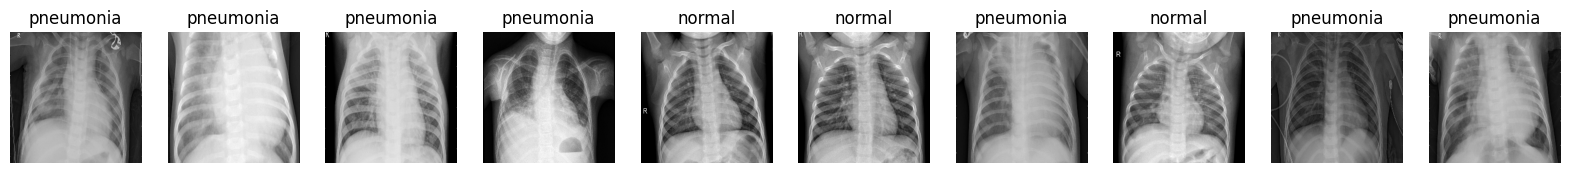

In [7]:
plt.figure(figsize = (20, 20))

for images, labels in train_data_Pneu.take(1):
  labels = np.array(labels).astype(int)
  for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.axis('off')
    plt.title(class_names[labels[i][0]])
    plt.imshow(images[i].numpy().astype('uint8'), cmap = 'gray')
plt.show()

#### Validation set

Loading Pneumonia validation set.

In [8]:
valid_data_Pneu = get_dataset('X-ray_image_classification/Pneumonia_dataset/val/')

Found 1053 files belonging to 2 classes.


Checking the number of the images, the number of healthy case images and the number of the pneumonia case images in validation set.

In [9]:
valid_images = glob.glob('X-ray_image_classification/Pneumonia_dataset/val/*/*')
normal_images = glob.glob('X-ray_image_classification/Pneumonia_dataset/val/normal/*')
pneumonia_images = glob.glob('X-ray_image_classification/Pneumonia_dataset/val/pneumonia/*')

image_count = len(valid_images)
normal_count =  len(normal_images)
pneumonia_count = len(pneumonia_images)

print('Number of all images in validation set: ', image_count)
print('Number of Healthy images in validation set: ', normal_count)
print('Number of Pneumonia images in validation set: ', pneumonia_count)

Number of all images in validation set:  1053
Number of Healthy images in validation set:  280
Number of Pneumonia images in validation set:  773


#### Test set

Loading Pneumonia test set.

In [10]:
test_data_Pneu = get_dataset('X-ray_image_classification/Pneumonia_dataset/test/')

Found 624 files belonging to 2 classes.


Checking the number of the images, the number of healthy case images and the number of the pneumonia case images in test set.

In [11]:
test_images = glob.glob('X-ray_image_classification/Pneumonia_dataset/test/*/*')
normal_images = glob.glob('X-ray_image_classification/Pneumonia_dataset/test/normal/*')
pneumonia_images = glob.glob('X-ray_image_classification/Pneumonia_dataset/test/pneumonia/*')

image_count = len(test_images)
normal_count =  len(normal_images)
pneumonia_count = len(pneumonia_images)

print('Number of all images in test set: ', image_count)
print('Number of Healthy images in test set: ', normal_count)
print('Number of Pneumonia images in test set: ', pneumonia_count)

Number of all images in test set:  624
Number of Healthy images in test set:  234
Number of Pneumonia images in test set:  390


### Covid-19 dataset

Covid-19 dataset consists of X-ray images of human chests. The chests are healthy ('normal') or they have pneumonia or covid-19.
The dataset has been formed from two other datasets: Covid-19 Image Dataset by Pranav Raikote [1] and COVID CXR Image Dataset (Research) by Manu Siddhartha [2]. The formation has been discussed in the other code file where the formation has been done and in the work report about the project.

The dataset has 853 images divided into train, valid and test folders with 542, 137 and 174 images, respectively. Images in those folders has been divided into covid, normal and pneumonia by their labels. The covid, normal and pneumonia folders in training set have 430, 56 and 56 images, respectively. The covid, normal and pneumonia folders in validation set have 109, 14 and 14 images, respectively. The covid, normal and pneumonia folders in test set have 134, 20 and 20 images, respectively.

All images are grayscale images with different sizes. Most of the images are jpeg format but other formats like png and jpg are used as well.

The datasets can be found from Kaggle:

[1] Pranav Raikote (updated 2020), Covid-19 Image Dataset, CC BY-SA 4.0 license, the data got from the University of Montreal,
https://www.kaggle.com/datasets/sid321axn/covid-cxr-image-dataset-research

[2] Manu Siddhartha (updated 2021), COVID CXR Image Dataset (Research), CC0 1.0 license, https://www.kaggle.com/datasets/sid321axn/covid-cxr-image-dataset-research?select=COVID_IEEE, acknowledgements for
1. D. Kermany, K. Zhang, M. Goldbaum, Large dataset of labeled optical coherence tomography (oct) and chest x-ray images, Mendeley Data, v3
http://dx. doi. org/10.17632/rscbjbr9sj 3 (2018).
2. C. J. P, P. Morrison, D. L, Covid-19 image data collection, arxiv, arXiv preprint arXiv:2003.11597 (2020). URL https://github.com/ieee8023/covid-chestxray-dataset
3. Z.-H. Chen, Mask-rcnn detection of covid-19 pneumonia symptoms by employing stacked autoencoders in deep unsupervised learning on low-dose
high resolution ct (2020). doi:10.21227/4kcm-m312.URL http://dx.doi.org/10.21227/4kcm-m312
4. D. S. et.al, Covid19action-radiology-cxr (2020). doi:10.21227/s7pw-jr18.
URL http://dx.doi.org/10.21227/s7pw-jr18

In this section the Covid-19 dataset is loaded. The training set, validation set and test set are loaded separately, in respective order. Let's use very similar function for loading them as the *get_dataset* function used for loading the Pneumonia dataset. The new *get_covid_dataset* differs with a few parameters: *shuffle*, *label_mode* and *class_names*.

The *get_covid_dataset* function sets the labels of the images to 0, 1 or 2 depending of the healthyness of the chests. 0 corresponds to a healthy chest and 1 a pneumonia case as before but 2 corresponds now to Covid-19. The shuffle changes depending what data is loaded: the test set data is not shuffled to dodge problems later and because there is no need to do that. Also, the label mode has to be something else than binary because of multilabeled data so it has been changed to integer.


In [12]:
def get_covid_dataset(file_path, shuffle):
  data = keras.utils.image_dataset_from_directory(
      file_path,
      labels = 'inferred',
      shuffle = shuffle,
      label_mode = 'int',
      class_names = ['normal', 'pneumonia', 'covid'],
      color_mode = "grayscale",
      batch_size = 32,
      image_size = (256, 256))
  return data

#### Training set

Loading Covid-19 training set.

In [13]:
train_data_C19 = get_covid_dataset('X-ray_image_classification/Covid-19_dataset_new_split/train/', True)

Found 542 files belonging to 3 classes.


Getting the class names of Covid-19 dataset.

In [14]:
class_names = train_data_C19.class_names

Checking the number of all images, the number of healthy, pneumonia and covid-19 case images in the training set.



In [15]:
training_images = glob.glob('X-ray_image_classification/Covid-19_dataset_new_split/train/*/*')
normal_images = glob.glob('X-ray_image_classification/Covid-19_dataset_new_split/train/normal/*')
pneumonia_images = glob.glob('X-ray_image_classification/Covid-19_dataset_new_split/train/pneumonia/*')
covid_images = glob.glob('X-ray_image_classification/Covid-19_dataset_new_split/train/covid/*')

image_count = len(training_images)
normal_count =  len(normal_images)
pneumonia_count = len(pneumonia_images)
covid_count = len(covid_images)

print('Number of all images in training set: ', image_count)
print('Number of Healthy images in training set: ', normal_count)
print('Number of Pneumonia images in training set: ', pneumonia_count)
print('Number of Covid-19 images in training set: ', covid_count)

Number of all images in training set:  542
Number of Healthy images in training set:  56
Number of Pneumonia images in training set:  56
Number of Covid-19 images in training set:  430


Printing the first 10 training set images and their corresponding labels.

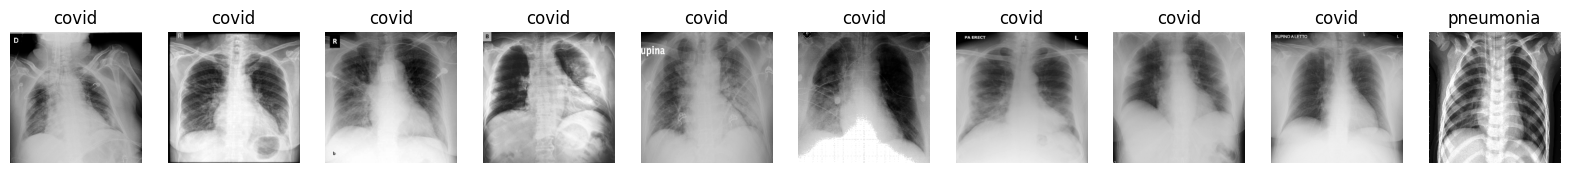

In [16]:
plt.figure(figsize = (20, 20))

for images, labels in train_data_C19.take(1):
  labels = np.array(labels).astype(int)
  for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.axis('off')
    plt.title(class_names[labels[i]])
    plt.imshow(images[i].numpy().astype('uint8'), cmap = 'gray')
plt.show()

#### Validation set

Loading Covid-19 validation set.

In [17]:
valid_data_C19 = get_covid_dataset('X-ray_image_classification/Covid-19_dataset_new_split/valid/', True)

Found 137 files belonging to 3 classes.


Checking the number of all images, the number of healthy, pneumonia and covid-19 case images in the validation set.

In [18]:
training_images = glob.glob('X-ray_image_classification/Covid-19_dataset_new_split/train/*/*')
normal_images = glob.glob('X-ray_image_classification/Covid-19_dataset_new_split/train/normal/*')
pneumonia_images = glob.glob('X-ray_image_classification/Covid-19_dataset_new_split/train/pneumonia/*')
covid_images = glob.glob('X-ray_image_classification/Covid-19_dataset_new_split/train/covid/*')

image_count = len(training_images)
normal_count =  len(normal_images)
pneumonia_count = len(pneumonia_images)
covid_count = len(covid_images)

print('Number of all images in validation set: ', image_count)
print('Number of Healthy images in validation set: ', normal_count)
print('Number of Pneumonia images in validation set: ', pneumonia_count)
print('Number of Covid-19 images in validation set: ', covid_count)

Number of all images in validation set:  542
Number of Healthy images in validation set:  56
Number of Pneumonia images in validation set:  56
Number of Covid-19 images in validation set:  430


#### Test set

Loading Covid-19 test set.

In [19]:
test_data_C19 = get_covid_dataset('X-ray_image_classification/Covid-19_dataset_new_split/test/', False)

Found 174 files belonging to 3 classes.


Checking the number of all images, the number of healthy, pneumonia and covid-19 case images in the test set.

In [20]:
training_images = glob.glob('X-ray_image_classification/Covid-19_dataset_new_split/train/*/*')
normal_images = glob.glob('X-ray_image_classification/Covid-19_dataset_new_split/train/normal/*')
pneumonia_images = glob.glob('X-ray_image_classification/Covid-19_dataset_new_split/train/pneumonia/*')
covid_images = glob.glob('X-ray_image_classification/Covid-19_dataset_new_split/train/covid/*')

image_count = len(training_images)
normal_count =  len(normal_images)
pneumonia_count = len(pneumonia_images)
covid_count = len(covid_images)

print('Number of all images in test set: ', image_count)
print('Number of Healthy images in test set: ', normal_count)
print('Number of Pneumonia images in test set: ', pneumonia_count)
print('Number of Covid-19 images in test set: ', covid_count)

Number of all images in test set:  542
Number of Healthy images in test set:  56
Number of Pneumonia images in test set:  56
Number of Covid-19 images in test set:  430


## Building the CNN model

In this section the image augmentation and rescaling of Pneumonia dataset images are done and the base model is initialized. The image augmentation and rescaling are built in the base model.

### Image Augmentation

The image augmentation layer is initialized. Images will be randomly rotated, flipped (horizontally), zoomed and translated (based width and height). The initialization is been utilized in base model.

In [21]:
img_augmentation = Sequential([
    keras.layers.experimental.preprocessing.RandomRotation(0.2),
    keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    keras.layers.experimental.preprocessing.RandomZoom(0.15),
    keras.layers.experimental.preprocessing.RandomTranslation(0.2, 0.2)
])

### Initializing a base model

Creating the base model with image augmentation and rescaling of the images. First the input is initialized, then image augmentation and rescaling are applied. The pixels in the images are rescaled to range [0, 1].

After the preprocessing three convolutional layers and three maxpooling layers are initialized. Convolutional layers have kernel size (3, 3) and filters are 32, 64 and 128. Maxpooling layers have pool size (2, 2).

Then comes a flatten layer and then two dense layers. The dense layers have 500 and 100 neurons, respectively, and ReLUs as activation functions. The last one is the output layer having one neuron and sigmoid as the activation function because now there are only two classes in the dataset. Pneumonia dataset is used to train the initial model.

In [22]:
model = Sequential([
    Input(shape=(256, 256, 1)),
    img_augmentation,
    Rescaling(scale = 1./255),

    Conv2D(32, (3, 3), padding = 'same'),
    MaxPooling2D(pool_size = (2, 2), padding = 'same'),
    Conv2D(64, (3, 3), padding = 'same'),
    MaxPooling2D(pool_size = (2, 2), padding = 'same'),
    Conv2D(128, (3, 3), padding = 'same'),
    MaxPooling2D(pool_size = (2, 2), padding = 'same'),

    Flatten(),
    Dense(500, activation = keras.activations.relu),
    Dense(100, activation = keras.activations.relu),
    Dense(1,  activation = keras.activations.sigmoid)
])

Cheking the structure of the base model.

In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 1)       0         
                                                                 
 rescaling (Rescaling)       (None, 256, 256, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 64)        0         
 g2D)                                                 

## Training the base model with Pneumonia dataset

Initializing loss, optimizer and metrics used to measure the goodness of the model and compiling the base model. Binary versions of crossentropy and accuracy are used because the output of the base model is binary (either 0 or 1). Accuracy is used as the only metric and Adam is used as the optimizer.

In [24]:
loss = keras.losses.binary_crossentropy
optimizer =  keras.optimizers.Adam()
accuracy_metric = keras.metrics.binary_accuracy

model.compile(loss = loss, optimizer = optimizer, metrics = accuracy_metric)

Initializing a way to save the best version of the base model during training based on the validation accuracy.

In [25]:
checkpoint_filepath = 'X-ray_image_classification/checkpoint.best_base_model.keras'
model_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_binary_accuracy',
    mode='max',
    save_best_only=True)

Training the base model with Pneumonia training set, batch size of 32 and 20 epochs. Pneumonia validation set is used for validation and the best version of the base model is saved with a callback.

In [26]:
history = model.fit(train_data_Pneu,
                    batch_size = 32,
                    epochs = 20,
                    verbose = 2,
                    callbacks = [model_checkpoint],
                    validation_data = valid_data_Pneu)

Epoch 1/20
131/131 - 27s - loss: 0.9658 - binary_accuracy: 0.7266 - val_loss: 0.3846 - val_binary_accuracy: 0.8908 - 27s/epoch - 209ms/step
Epoch 2/20
131/131 - 18s - loss: 0.5039 - binary_accuracy: 0.7748 - val_loss: 0.4303 - val_binary_accuracy: 0.8632 - 18s/epoch - 140ms/step
Epoch 3/20
131/131 - 20s - loss: 0.3468 - binary_accuracy: 0.8454 - val_loss: 0.2500 - val_binary_accuracy: 0.9069 - 20s/epoch - 149ms/step
Epoch 4/20
131/131 - 18s - loss: 0.3110 - binary_accuracy: 0.8578 - val_loss: 0.2771 - val_binary_accuracy: 0.8775 - 18s/epoch - 137ms/step
Epoch 5/20
131/131 - 16s - loss: 0.2785 - binary_accuracy: 0.8686 - val_loss: 0.3035 - val_binary_accuracy: 0.8927 - 16s/epoch - 123ms/step
Epoch 6/20
131/131 - 16s - loss: 0.2811 - binary_accuracy: 0.8702 - val_loss: 0.2610 - val_binary_accuracy: 0.8889 - 16s/epoch - 119ms/step
Epoch 7/20
131/131 - 19s - loss: 0.2910 - binary_accuracy: 0.8760 - val_loss: 0.2123 - val_binary_accuracy: 0.9183 - 19s/epoch - 145ms/step
Epoch 8/20
131/131 -

## Evaluation of the base model


Saving the history parameters of the base model and printing them.

In [27]:
history_params = history.params
history_epochs = history.epoch
history_data = history.history

print(history_params)
print(history_epochs)
print(history_data.keys())

{'verbose': 2, 'epochs': 20, 'steps': 131}
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


Plotting the training and validation losses and accuracies.

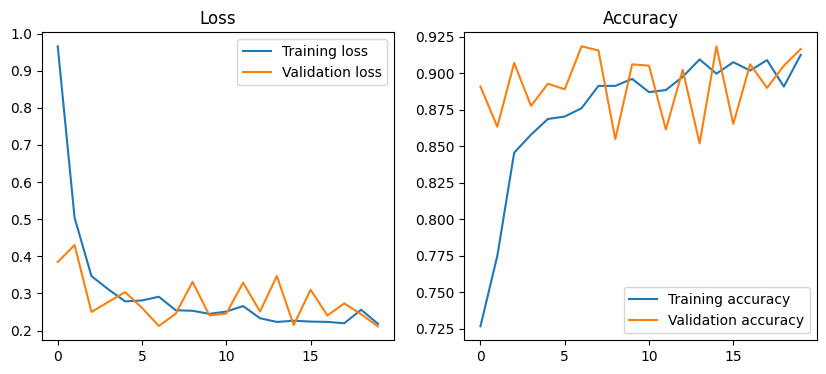

In [28]:
plt.figure(figsize = (10, 4))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history_data['loss'], label = 'Training loss')
plt.plot(history_data['val_loss'], label = 'Validation loss')
plt.title('Loss')
plt.legend(loc = "upper right")

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_data['binary_accuracy'], label = 'Training accuracy')
plt.plot(history_data['val_binary_accuracy'], label = 'Validation accuracy')
plt.title('Accuracy')
plt.legend(loc = 'lower right')

plt.show()

Loading the best version of the base model.

In [29]:
best_model = keras.models.load_model(checkpoint_filepath)

Evaluation of the base model with Pneumonia test set.

In [30]:
best_model_evaluation = best_model.evaluate(test_data_Pneu, verbose = 2)

20/20 - 2s - loss: 0.4084 - binary_accuracy: 0.8494 - 2s/epoch - 110ms/step


Copying the base model from variable to another.

In [31]:
base_model = best_model

## Saving and loading the base model

#### Saving the base model

Uncomment the model save from below if needed for example for testing different base model versions.

In [32]:
#model.save("X-ray_image_classification/base_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#### Loading the base model

Uncomment the model load from below if needed for example for testing different base model versions.

In [33]:
#base_model = keras.models.load_model("X-ray_image_classification/base_model.h5")

## Fine-tuning the partially frozen base model with Covid-19 dataset

Initializing a new model based on the base model. First the input shape is defined. Then all of the base model layers are added to the new model except the output layer. Lastly three new dense layers are added on top of the base model. The first two have 100 neurons and ReLU as the activation function. The last one is an output layer with 3 neurons and softmax as an activation function. Because Covid-19 training set is used to train the new model and it has three classes, the binary output and parameters can't be used anymore.

In [34]:
new_model = Sequential([Input(shape=(256, 256, 1))])

for layer in base_model.layers[:-1]:
  layer.trainable = False
  new_model.add(layer)

new_model.add(Dense(100, keras.activations.relu))
new_model.add(Dense(100, keras.activations.relu))
new_model.add(Dense(3, keras.activations.softmax))

Cheking the structure of the model.

In [35]:
new_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 1)       0         
                                                                 
 rescaling (Rescaling)       (None, 256, 256, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 64)        0         
 g2D)                                                 

Initializing loss, optimizer and the metrics used to measure the goodness of the model and compiling the base model. Sparse categorical crossentropy and sparse categorical accuracy are used for the same reason as the output layer is changed.
Accuracy is used as the only metric and optimizer is Adam.

In [36]:
loss = keras.losses.sparse_categorical_crossentropy
optimizer =  keras.optimizers.Adam()
accuracy_metric = keras.metrics.sparse_categorical_accuracy

new_model.compile(loss = loss, optimizer = optimizer, metrics = accuracy_metric)

Initializing a way to save the best version of the model during training based on the validation accuracy.

In [37]:
checkpoint_filepath = 'X-ray_image_classification/checkpoint.best_c19_model.keras'
new_model_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_sparse_categorical_accuracy',
    mode='max',
    save_best_only=True)

Training the model with Covid-19 training set, batch size of 32 and 15 epochs. Covid-19 validation set is used for validation and the best version of the model is saved with a callback.

In [38]:
history = new_model.fit(train_data_C19,
                        batch_size = 32,
                        epochs = 15,
                        verbose = 2,
                        callbacks = [new_model_checkpoint],
                        validation_data = valid_data_C19)

Epoch 1/15
17/17 - 5s - loss: 0.6445 - sparse_categorical_accuracy: 0.7491 - val_loss: 0.4292 - val_sparse_categorical_accuracy: 0.8467 - 5s/epoch - 315ms/step
Epoch 2/15
17/17 - 3s - loss: 0.3934 - sparse_categorical_accuracy: 0.8506 - val_loss: 0.3441 - val_sparse_categorical_accuracy: 0.8686 - 3s/epoch - 201ms/step
Epoch 3/15
17/17 - 2s - loss: 0.3198 - sparse_categorical_accuracy: 0.8764 - val_loss: 0.3311 - val_sparse_categorical_accuracy: 0.8613 - 2s/epoch - 132ms/step
Epoch 4/15
17/17 - 3s - loss: 0.3015 - sparse_categorical_accuracy: 0.8856 - val_loss: 0.2764 - val_sparse_categorical_accuracy: 0.8832 - 3s/epoch - 157ms/step
Epoch 5/15
17/17 - 2s - loss: 0.3077 - sparse_categorical_accuracy: 0.8782 - val_loss: 0.2818 - val_sparse_categorical_accuracy: 0.8832 - 2s/epoch - 130ms/step
Epoch 6/15
17/17 - 3s - loss: 0.2824 - sparse_categorical_accuracy: 0.8911 - val_loss: 0.2765 - val_sparse_categorical_accuracy: 0.9124 - 3s/epoch - 153ms/step
Epoch 7/15
17/17 - 2s - loss: 0.2817 - s

Saving the history parameters of the fine-tuned model and printing them.

In [39]:
history_params = history.params
history_epochs = history.epoch
history_data = history.history

print(history_params)
print(history_epochs)
print(history_data.keys())

{'verbose': 2, 'epochs': 15, 'steps': 17}
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


Plotting the training and validation losses and their accuracies.

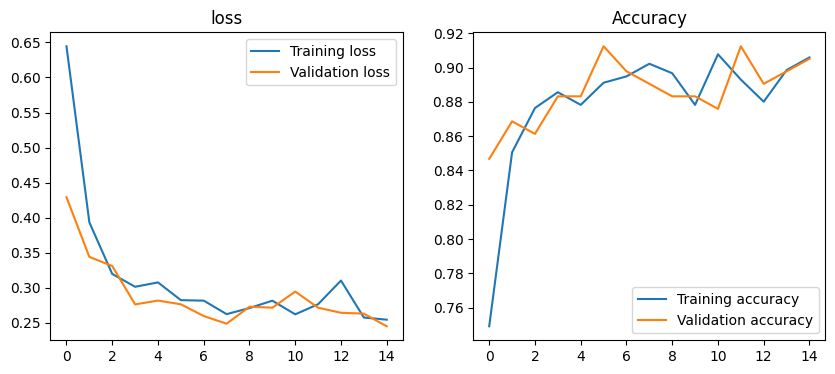

In [40]:
plt.figure(figsize = (10, 4))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history_data['loss'], label = 'Training loss')
plt.plot(history_data['val_loss'], label = 'Validation loss')
plt.title('loss')
plt.legend(loc = "upper right")

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_data['sparse_categorical_accuracy'], label = 'Training accuracy')
plt.plot(history_data['val_sparse_categorical_accuracy'], label = 'Validation accuracy')
plt.title('Accuracy')
plt.legend(loc = 'lower right')

plt.show()

## Evaluation of the fine-tuned model

Loading the best version of the fine-tuned model.

In [41]:
best_new_model = keras.models.load_model(checkpoint_filepath)

Evaluation of the fine-tuned model with Covid-19 test set.

In [42]:
model_evaluation = best_new_model.evaluate(test_data_C19, verbose = 2)

6/6 - 1s - loss: 0.2196 - sparse_categorical_accuracy: 0.9253 - 991ms/epoch - 165ms/step


Copying the fine-tuned model from variable to another.

In [43]:
fine_tuned_model = best_new_model

### Saving and loading the fine-tuned model

#### Saving the fine-tuned model

Uncomment the model save from below if needed for example for testing different base model versions.

In [44]:
#best_new_model.save("X-ray_image_classification/fine_tuned_model.h5")

#### Loading the fine-tuned model

Uncomment the model load from below if needed for example for testing different base model versions.

In [45]:
#fine_tuned_model = keras.models.load_model("X-ray_image_classification/fine_tuned_model.h5")

## Prediction

In this section some predictions are made with the final model (fine-tuned model) for testing that it functions correctly. The final model is tested with the test set of Covid-19 dataset.

Predicting classes. Changing the output from being a vector of probabilities to be a single integer value (the predicted class).

In [46]:
predictions = fine_tuned_model.predict(test_data_C19)
predictions = np.argmax(predictions, axis = 1)
print(len(predictions))

6/6 [==============================] - 1s 93ms/step
174


Printing the predictions.

In [47]:
print(predictions)

[2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 0 1 0 0 2 0 1 1 1 0 0 0 1 1 0]


Printing the true labels.

In [48]:
for images, labels in test_data_C19.take(20):
  print(np.array(labels).astype(int))

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1]


Checking the 30 first images with their predicted classes and their true classes (in brackets).

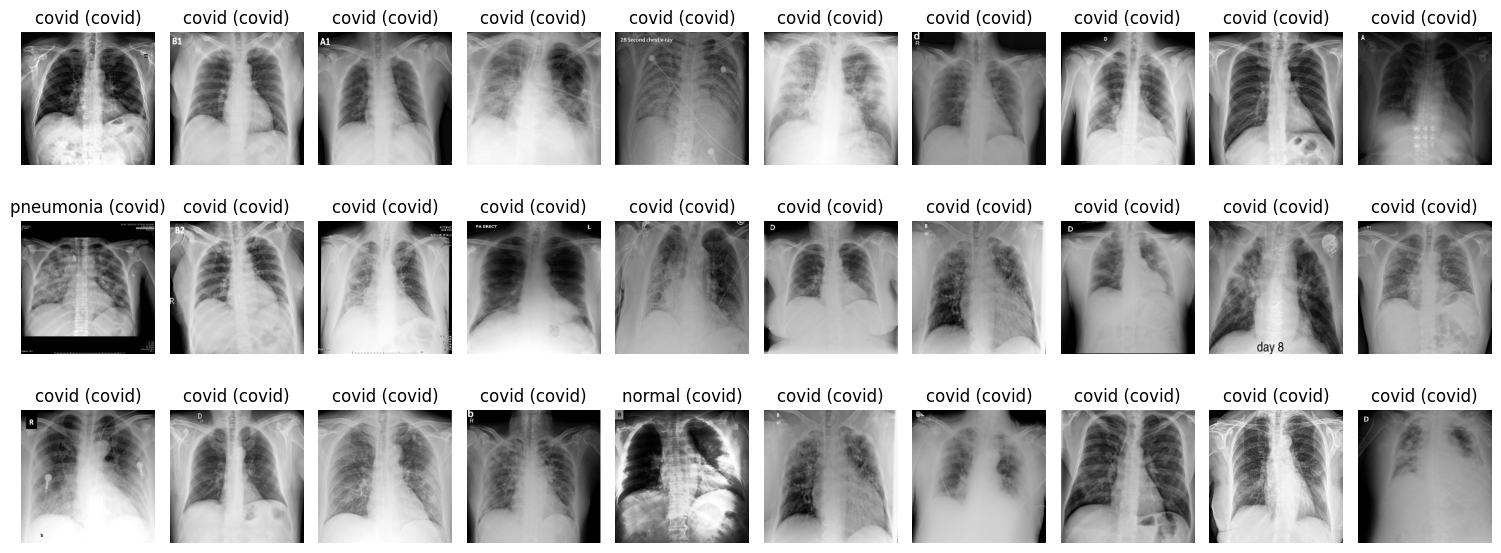

In [49]:
plt.figure(figsize = (15, 6))
for images, labels in test_data_C19.take(1):
  labels = np.array(labels).astype(int)
  for i in range(0, 30):
    plt.subplot(3, 10, i+1)
    plt.axis('off')
    plt.title(str(class_names[predictions[i]]) + ' (' + str(class_names[labels[i]]) + ')')
    plt.imshow(images[i].numpy().astype('uint8'), cmap = 'gray')
plt.tight_layout()
plt.show()

Creating a confusion matrix to check out the distribution of the class predictions. The numbers in the matrix are the counts of predicted labels classified correctly or incorrectly. If labels are classified incorrectly the matrix tells the classes and counts the labels has been classified. As a reminder: 0 is healthy case, 1 is pneumonia and 2 is covid-19.

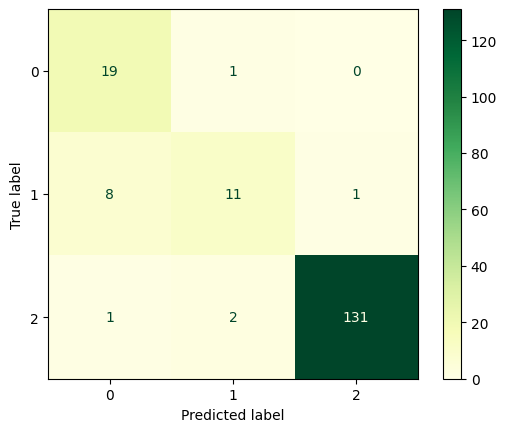

In [50]:
test_data_labels = np.empty([0, 1], int)
for images, labels in test_data_C19.take(15):
  labels = np.array(labels).astype(int)
  for label in labels:
    test_data_labels = np.append(test_data_labels, label)

ConfusionMatrixDisplay.from_predictions(test_data_labels,
                                        predictions,
                                        cmap = 'YlGn')
plt.show()

Creating the same confusion matrix but it has the percentages of each possible combination instead of counts.

In [51]:
result = confusion_matrix(test_data_labels, predictions, normalize='pred')
print('           Normal', '     Pneumonia', ' Covid-19')
print('Normal   ', result[0])
print('Pneumonia', result[1])
print('Covid-19 ', result[2])

           Normal      Pneumonia  Covid-19
Normal    [0.67857143 0.07142857 0.        ]
Pneumonia [0.28571429 0.78571429 0.00757576]
Covid-19  [0.03571429 0.14285714 0.99242424]


## Usage of the model

Load your image to be classified here.

In [52]:
# Opening an input image.
image = PIL.Image.open('X-ray_image_classification/Covid-19_dataset_new_split/test/covid/image0.png')
image = np.array(PIL.ImageOps.grayscale(image).resize((256, 256)))
image = np.expand_dims(image, 0)

In [53]:
# Predicting the label of the input image.
prediction = fine_tuned_model.predict(image)
prediction = np.argmax(prediction, axis = 1)

# Converting the predicted label into a more readable form and printing it as
# an output.
if prediction == 0:
  print('Healthy')
elif prediction == 1:
  print('Pneumonia')
elif prediction == 2:
  print('Covid-19')

1/1 [==============================] - 0s 356ms/step
Covid-19
